Text(0.5, 1.0, 'Convolved Gaussian Random Walk')

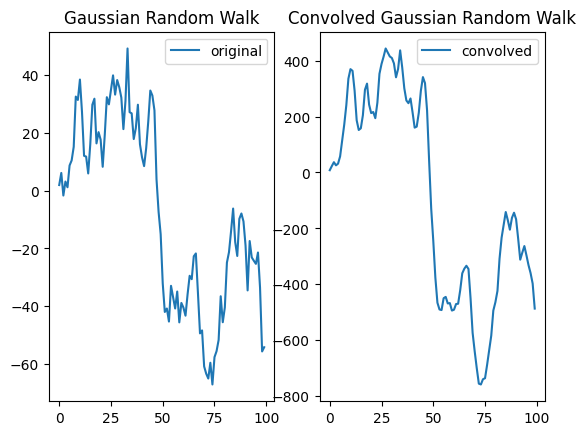

In [8]:
import numpy as np
# import skimage.measure
import pandas as pd
from scipy.stats import mode
from pathlib import Path
from matplotlib import pyplot as plt
 
x=np.random.normal(0,10,100)
y=np.cumsum(x)
z=np.array([1,1,2,5,3])
y_convolved=np.convolve(y,z,mode='same')
y_convolved = np.matrix(y_convolved).T

fig, ax = plt.subplots(1, 2)

ax[0].plot(y,label='original')
ax[0].legend()
ax[0].set_title('Gaussian Random Walk')
 
ax[1].plot(y_convolved,label='convolved')
ax[1].legend()
ax[1].set_title('Convolved Gaussian Random Walk')

In [2]:
# import skimage.measure

# average_pooling = skimage.measure.block_reduce(y_convolved, (3,1), np.mean)
 
# plt.plot(average_pooling,label='average pooling')
# plt.legend()
# plt.title('Average Pooling of Convolved Gaussian Random Walk')

ModuleNotFoundError: No module named 'skimage'

# Real data: Activity Recognition

In [3]:
from pathlib import Path

print(Path())

.


In [11]:
from pathlib import Path

DATASET_HAR = Path() / "datasets/human_activity_recognition/kaggle"

participant_file_names = []
participants = []
for i in range(1, 10):
    file_path = DATASET_HAR / f"{i}.csv"
    data = pd.read_csv(Path(file_path), header=None)
    participant_file_names.append(data.to_numpy())
    participants.append(data.to_numpy())
    
participants_train = [participants[0]]

In [14]:
print(participants_train[0])

[[0.000e+00 1.502e+03 2.215e+03 2.153e+03 1.000e+00]
 [1.000e+00 1.667e+03 2.072e+03 2.047e+03 1.000e+00]
 [2.000e+00 1.611e+03 1.957e+03 1.906e+03 1.000e+00]
 ...
 [1.625e+05 1.929e+03 2.385e+03 2.076e+03 7.000e+00]
 [1.625e+05 1.926e+03 2.385e+03 2.078e+03 7.000e+00]
 [1.625e+05 1.922e+03 2.387e+03 2.078e+03 0.000e+00]]


In [12]:
len(participant_file_names)

9

In [5]:
participant_file_names[0].shape

(162501, 5)

In [7]:
full_participant_file_names = pd.concat(participant_file_names)
full_participant_file_names.shape

(1293689, 5)

In [85]:
n = 0
p = 50
TIME_PERIODS = p
num_sensors = 1
x = []
y = []

for k in range(len(participants_train)):
    x_participant = pd.DataFrame(participants_train[k][:, 1])
    x_participant = pd.concat([x_participant.shift(i) for i in range(p)], axis=1).dropna()
    
    y_participant = pd.DataFrame(participants_train[k][:, 4])
    y_participant = y_participant[p-1:]
    
    x.append(x_participant)
    y.append(y_participant)
    
print(len(x), x[0].shape, x[len(x) - 1].shape)

1 (162452, 50) (162452, 50)


In [95]:
print(len(x), x[0].shape)

x = np.vstack(x)
x = np.expand_dims(x, 2)
x.shape

1 (162452, 50)


(162452, 50, 1)

In [96]:
print(len(y), y[0].shape)
y = np.hstack(y)
y = y.flatten()
y.shape

1 (162452, 1)


(162452,)

In [104]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [98]:
y

array([1., 1., 1., ..., 7., 7., 0.])

In [99]:
print(to_categorical(y))

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [101]:
y_binary = to_categorical(y)
print(y_binary.shape)

(162452, 8)


In [102]:
n_filters = 4
filter_size = 3
pool_size = 2

In [148]:
tf.random.set_seed(1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((TIME_PERIODS, num_sensors), input_shape=(TIME_PERIODS, num_sensors)),
    tf.keras.layers.Conv1D(n_filters, filter_size, activation='relu', padding='same', input_shape=(TIME_PERIODS, num_sensors)),
    tf.keras.layers.Conv1D(n_filters, filter_size, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(y_binary.shape[1])
])

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='adam')
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)
model.fit(x, y_binary, batch_size=64, epochs=1)

2539/2539 [==============================] - 9s 3ms/step - loss: 14.5537 - accuracy: 0.0176


In [135]:
# batch_size = 64

# train_dataset = tf.data.Dataset.from_tensor_slices((x, y_binary))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# epochs = 1
# for epoch in range(epochs):
    
#     for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
#         with tf.GradientTape() as tape:
#             logits = model(x_batch_train, training=True)
#             loss_value = loss_fn(y_batch_train, logits)
            
#         grads = tape.gradient(loss_value, model.trainable_weights)
#         adam.apply_gradients(zip(grads, model.trainable_weights))
        
#         if step % 5 == 0:
#             print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
#             print("Seen so far: %s samples" % ((step + 1) * batch_size))

Training loss (for one batch) at step 0: nan
Seen so far: 64 samples
Training loss (for one batch) at step 5: nan
Seen so far: 384 samples
Training loss (for one batch) at step 10: nan
Seen so far: 704 samples
Training loss (for one batch) at step 15: nan
Seen so far: 1024 samples
Training loss (for one batch) at step 20: nan
Seen so far: 1344 samples
Training loss (for one batch) at step 25: nan
Seen so far: 1664 samples
Training loss (for one batch) at step 30: nan
Seen so far: 1984 samples
Training loss (for one batch) at step 35: nan
Seen so far: 2304 samples
Training loss (for one batch) at step 40: nan
Seen so far: 2624 samples
Training loss (for one batch) at step 45: nan
Seen so far: 2944 samples
Training loss (for one batch) at step 50: nan
Seen so far: 3264 samples
Training loss (for one batch) at step 55: nan
Seen so far: 3584 samples
Training loss (for one batch) at step 60: nan
Seen so far: 3904 samples
Training loss (for one batch) at step 65: nan
Seen so far: 4224 sample

In [157]:
intermediate_layer_index = 2
intermediate_layer_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(index=intermediate_layer_index).output
)
x_predict = np.matrix(x[50000, :, :])
print(x_predict.shape)
x_predict = np.expand_dims(x_predict, 0)
print(x_predict.shape)
intermediate_output = intermediate_layer_model.predict(x_predict)
print(intermediate_output.shape)

(50, 1)
(1, 50, 1)


1/1 [==============================] - 0s 75ms/step
(1, 48, 4)


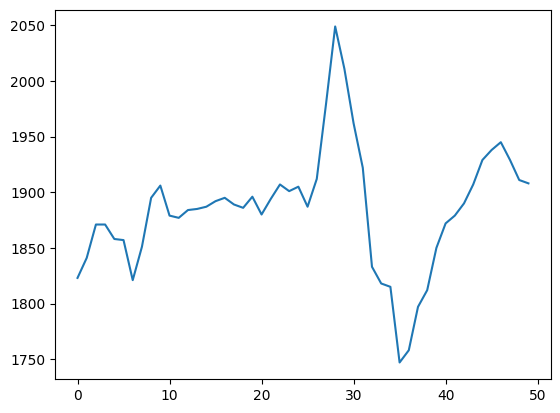

In [158]:
plt.plot(x_predict[0, :, :])

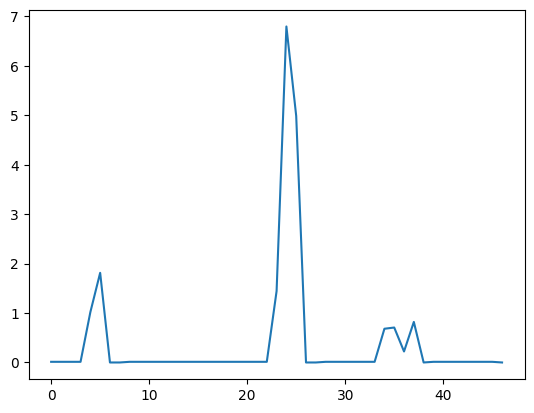

In [159]:
plt.plot(intermediate_output[0, 1:48, 1])

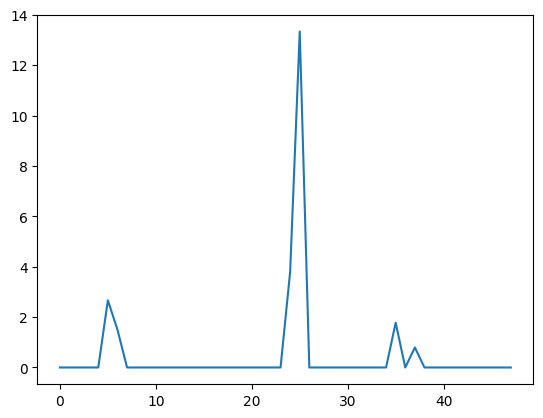

In [160]:
plt.plot(intermediate_output[0, :, 0])

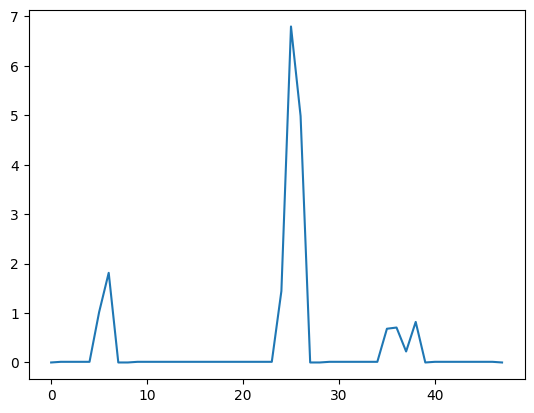

In [161]:
plt.plot(intermediate_output[0, :, 1])

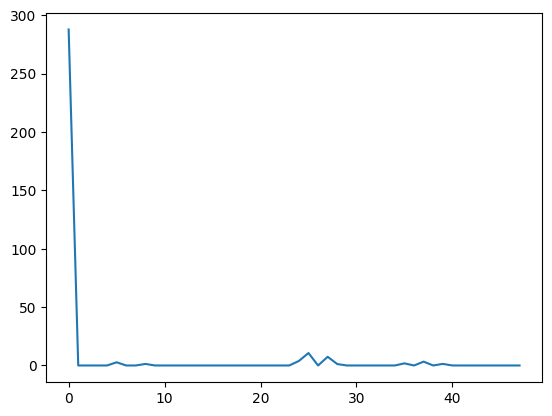

In [162]:
plt.plot(intermediate_output[0, :, 2])

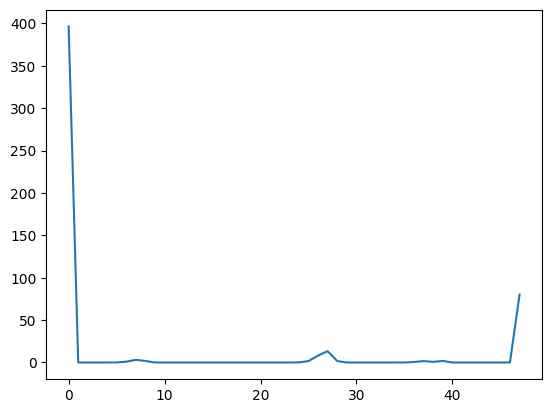

In [163]:
plt.plot(intermediate_output[0, :, 3])

In [154]:
intermediate_output

array([[[  0.       ,   0.       , 938.1789   ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   5.708251 ,   0.       ],
        [  0.       ,   0.       ,   4.311561 ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        